In [1]:
# Cell 1: Setup and Load Processed Data
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_root = Path.cwd()
for up in [repo_root, repo_root.parent, repo_root.parent.parent]:
    if (up / "src").exists():
        repo_root = up
        break

import sys
sys.path.insert(0, str(repo_root))

# Import EKF
from src.ekf_model import CoordinatedTurnEKF, EKFParams

# Load data
DATA = repo_root / "data" / "processed" / "flights_nativecadence_enu_kinematics.parquet"
df = pd.read_parquet(DATA)

print(f"Loaded {len(df):,} rows")
print(f"Unique flights: {df['flight_id'].nunique()}")
print(f"Continuous runs: {df.groupby(['flight_id', 'run_id']).ngroups}")

# Quick data quality check
print("\nData quality check:")
print(f"Speed range: {df['speed'].min():.1f} - {df['speed'].max():.1f} m/s")
print(f"E range: {df['E'].min():.1f} - {df['E'].max():.1f} m")
print(f"N range: {df['N'].min():.1f} - {df['N'].max():.1f} m")

Loaded 1,038,555 rows
Unique flights: 5335
Continuous runs: 5492

Data quality check:
Speed range: 0.0 - 961.4 m/s
E range: -2126501.6 - 1486336.5 m
N range: -1423972.7 - 1576440.1 m


In [2]:
# Cell 2: Identify High-Quality Runs for EKF Testing
# Calculate run-level statistics to find good candidates
gb = df.groupby(['flight_id', 'run_id'], sort=False)

run_stats = gb.agg(
    n_points=('time', 'count'),
    duration_min=('time', lambda x: (x.max() - x.min()).total_seconds() / 60),
    dt_median=('dt', 'median'),
    E_max=('E', lambda x: x.abs().max()),
    N_max=('N', lambda x: x.abs().max()),
    U_range=('U', lambda x: x.max() - x.min()),
    speed_p95=('speed', lambda x: x.quantile(0.95) if x.notna().any() else np.nan),
    speed_max=('speed', 'max'),
    vE_std=('vE', lambda x: x.std() if x.notna().any() else np.nan),
    vN_std=('vN', lambda x: x.std() if x.notna().any() else np.nan)
).reset_index()

# Define quality criteria for EKF testing
QUALITY_FILTERS = {
    'duration_min': (5, 60),      # 5-60 minutes
    'dt_median': (5, 30),          # 5-30 second cadence
    'E_max': (0, 500_000),         # Max 500km from origin
    'N_max': (0, 500_000),         # Max 500km from origin
    'U_range': (0, 15_000),        # Max 15km altitude change
    'speed_p95': (50, 350),        # 50-350 m/s (100-680 knots)
    'n_points': (100, 400)         # Enough points for training/testing
}

# Apply filters
mask = pd.Series(True, index=run_stats.index)
for col, (vmin, vmax) in QUALITY_FILTERS.items():
    if col in run_stats.columns:
        mask &= (run_stats[col] >= vmin) & (run_stats[col] <= vmax)

good_runs = run_stats[mask].copy()
print(f"Found {len(good_runs)} high-quality runs out of {len(run_stats)}")
print(f"That's {len(good_runs)/len(run_stats)*100:.1f}% of all runs\n")

# Show distribution of good runs
print("High-quality run statistics:")
print(good_runs[['duration_min', 'dt_median', 'speed_p95', 'E_max', 'N_max']].describe().round(1))

# Select diverse sample for testing (different speeds and durations)
test_runs = good_runs.nlargest(20, 'duration_min').head(10)
print(f"\nSelected {len(test_runs)} test runs with longest durations")

Found 1934 high-quality runs out of 5492
That's 35.2% of all runs

High-quality run statistics:
       duration_min  dt_median  speed_p95     E_max     N_max
count        1934.0     1934.0     1934.0    1934.0    1934.0
mean           27.7       10.0      224.5  141231.7  111127.3
std             9.2        0.0       71.9  108232.5   92061.5
min            16.5       10.0       52.1     485.6      41.2
25%            20.5       10.0      175.0   48512.2   38496.1
50%            25.5       10.0      240.4  117276.8   86878.3
75%            32.5       10.0      275.7  218917.7  163056.6
max            59.7       10.0      349.9  490459.2  466687.5

Selected 10 test runs with longest durations


Testing on flight 15, run 0
Duration: 59.7 min, Points: 359.0


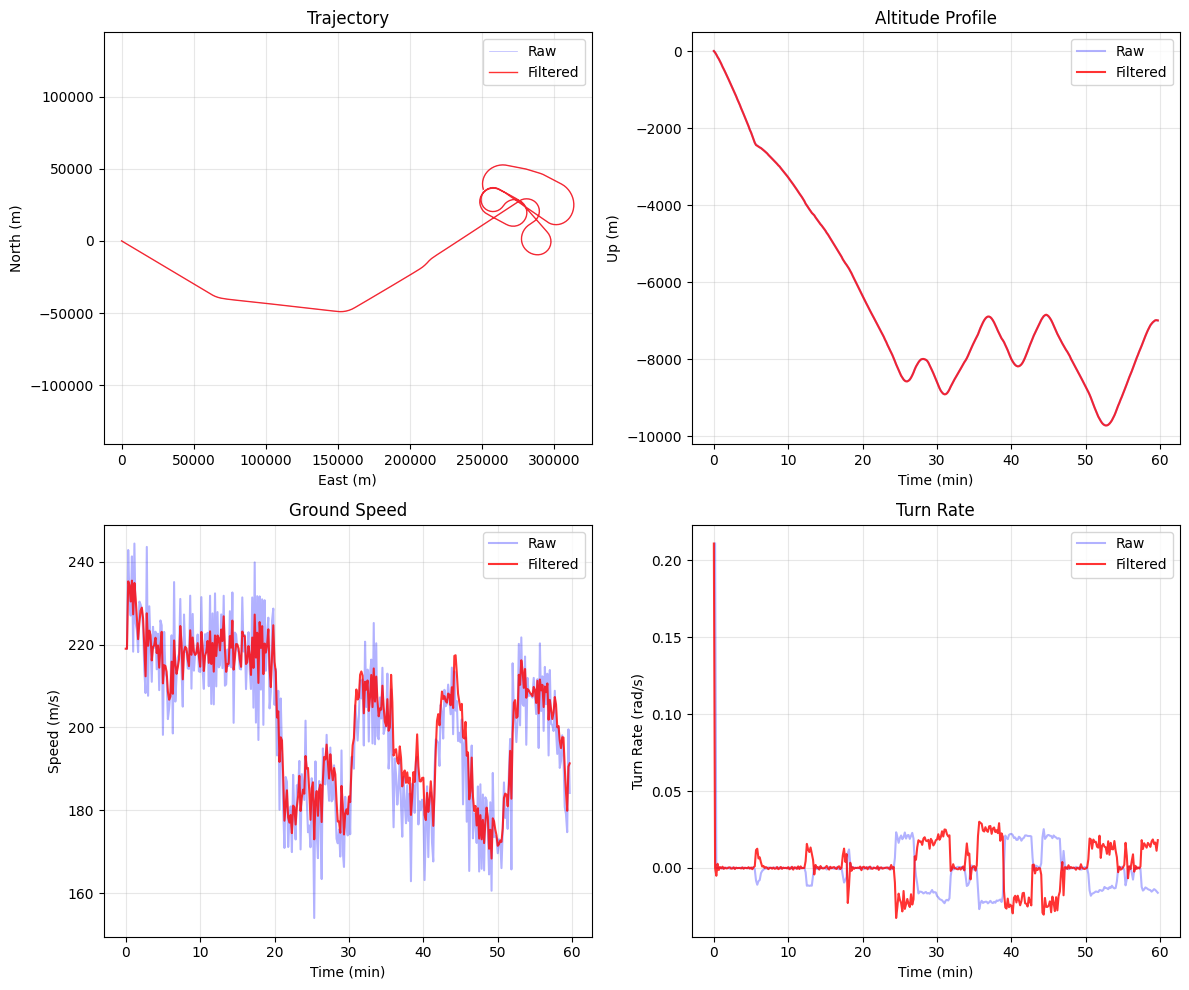


Filtering complete. Checking for issues...
Max position error: 54.6 m


In [3]:
# Cell 3: Test EKF on Single Run
# Pick one run and test EKF filtering
test_run = test_runs.iloc[0]
fid, rid = int(test_run['flight_id']), int(test_run['run_id'])

print(f"Testing on flight {fid}, run {rid}")
print(f"Duration: {test_run['duration_min']:.1f} min, Points: {test_run['n_points']}")

# Extract the track
track = df[(df['flight_id'] == fid) & (df['run_id'] == rid)].copy()
track = track.sort_values('time').reset_index(drop=True)

# Ensure required columns exist and are finite
required_cols = ['time', 'E', 'N', 'U', 'vE', 'vN', 'vU', 'turn_rate', 'dt']
for col in required_cols:
    if col not in track.columns:
        if col == 'turn_rate':
            track[col] = 0.0
        elif col == 'dt':
            track[col] = track['time'].diff().dt.total_seconds().fillna(10.0)
        else:
            track[col] = 0.0

# Initialize and run EKF
ekf = CoordinatedTurnEKF(EKFParams(
    sigma_pos=10.0,      # Increased from 5.0 for noisy ADS-B
    sigma_vel=2.0,       # Increased from 1.0
    sigma_omega=0.02,    # Increased from 0.01
    sigma_meas_pos=50.0  # Increased from 30.0 for ADS-B accuracy
))

# Run filter
filtered = ekf.filter_track(track)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# E-N trajectory
ax = axes[0, 0]
ax.plot(track['E'], track['N'], 'b-', alpha=0.3, label='Raw', linewidth=0.5)
ax.plot(filtered['E_hat'], filtered['N_hat'], 'r-', alpha=0.8, label='Filtered', linewidth=1)
ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Altitude profile
ax = axes[0, 1]
time_min = (track['time'] - track['time'].iloc[0]).dt.total_seconds() / 60
ax.plot(time_min, track['U'], 'b-', alpha=0.3, label='Raw')
ax.plot(time_min, filtered['U_hat'], 'r-', alpha=0.8, label='Filtered')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Up (m)')
ax.set_title('Altitude Profile')
ax.legend()
ax.grid(True, alpha=0.3)

# Speed
ax = axes[1, 0]
track['speed'] = np.sqrt(track['vE']**2 + track['vN']**2)
filtered['speed_hat'] = np.sqrt(filtered['vE_hat']**2 + filtered['vN_hat']**2)
ax.plot(time_min, track['speed'], 'b-', alpha=0.3, label='Raw')
ax.plot(time_min, filtered['speed_hat'], 'r-', alpha=0.8, label='Filtered')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (m/s)')
ax.set_title('Ground Speed')
ax.legend()
ax.grid(True, alpha=0.3)

# Turn rate
ax = axes[1, 1]
ax.plot(time_min, track['turn_rate'], 'b-', alpha=0.3, label='Raw')
ax.plot(time_min, filtered['omega_hat'], 'r-', alpha=0.8, label='Filtered')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Turn Rate (rad/s)')
ax.set_title('Turn Rate')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFiltering complete. Checking for issues...")
print(f"Max position error: {np.sqrt((track['E'] - filtered['E_hat'])**2 + (track['N'] - filtered['N_hat'])**2).max():.1f} m")

Prediction Results:
--------------------------------------------------

Horizon: 60s
  Matched pairs: 356
  RMSE 2D: 2647.4 m
  RMSE 3D: 2651.8 m
  MAE 2D: 1737.9 m
  Max error: 14170.1 m

Horizon: 120s
  Matched pairs: 350
  RMSE 2D: 10151.4 m
  RMSE 3D: 10161.4 m
  MAE 2D: 7133.4 m
  Max error: 32061.5 m

Horizon: 300s
  Matched pairs: 332
  RMSE 2D: 55800.3 m
  RMSE 3D: 55823.1 m
  MAE 2D: 34040.1 m
  Max error: 737775.2 m


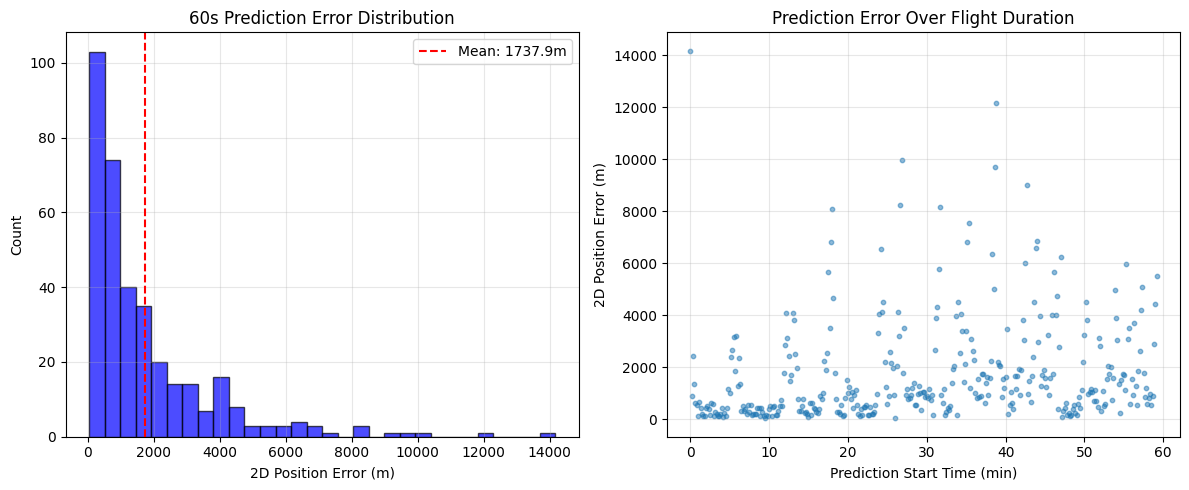

In [4]:
# Cell 4: Test Prediction at Different Horizons
# Test forecasting from filtered states
HORIZONS = [60, 120, 300]  # seconds
TOLERANCE = 30  # seconds for matching predictions to truth

# Use the same track from previous cell
results = ekf.horizon_errors(
    track=track,
    filt=filtered, 
    horizons_s=HORIZONS,
    tol_s=TOLERANCE
)

# Analyze prediction errors
print("Prediction Results:")
print("-" * 50)
for H in HORIZONS:
    if H in results and len(results[H]) > 0:
        res_df = results[H]
        rmse_2d = np.sqrt(np.mean(res_df['eE']**2 + res_df['eN']**2))
        rmse_3d = np.sqrt(np.mean(res_df['err_m']**2))
        mae_2d = np.mean(np.sqrt(res_df['eE']**2 + res_df['eN']**2))
        
        print(f"\nHorizon: {H}s")
        print(f"  Matched pairs: {len(res_df)}")
        print(f"  RMSE 2D: {rmse_2d:.1f} m")
        print(f"  RMSE 3D: {rmse_3d:.1f} m")
        print(f"  MAE 2D: {mae_2d:.1f} m")
        print(f"  Max error: {res_df['err_m'].max():.1f} m")
    else:
        print(f"\nHorizon: {H}s - No valid predictions")

# Visualize predictions for 60s horizon
if 60 in results and len(results[60]) > 0:
    res_60 = results[60]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Error distribution
    ax = axes[0]
    err_2d = np.sqrt(res_60['eE']**2 + res_60['eN']**2)
    ax.hist(err_2d, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(err_2d.mean(), color='red', linestyle='--', label=f'Mean: {err_2d.mean():.1f}m')
    ax.set_xlabel('2D Position Error (m)')
    ax.set_ylabel('Count')
    ax.set_title('60s Prediction Error Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Error over time
    ax = axes[1]
    pred_time_min = (res_60['src_time'] - track['time'].iloc[0]).dt.total_seconds() / 60
    ax.scatter(pred_time_min, err_2d, alpha=0.5, s=10)
    ax.set_xlabel('Prediction Start Time (min)')
    ax.set_ylabel('2D Position Error (m)')
    ax.set_title('Prediction Error Over Flight Duration')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Data Quality Diagnostics:
--------------------------------------------------
Median speed: 200.6 m/s
Max position jump: 2443.9 m
Jumps > 1km: 358
Jumps > 5km: 0

Large jumps found at indices: [1, 2, 3, 4, 5]...


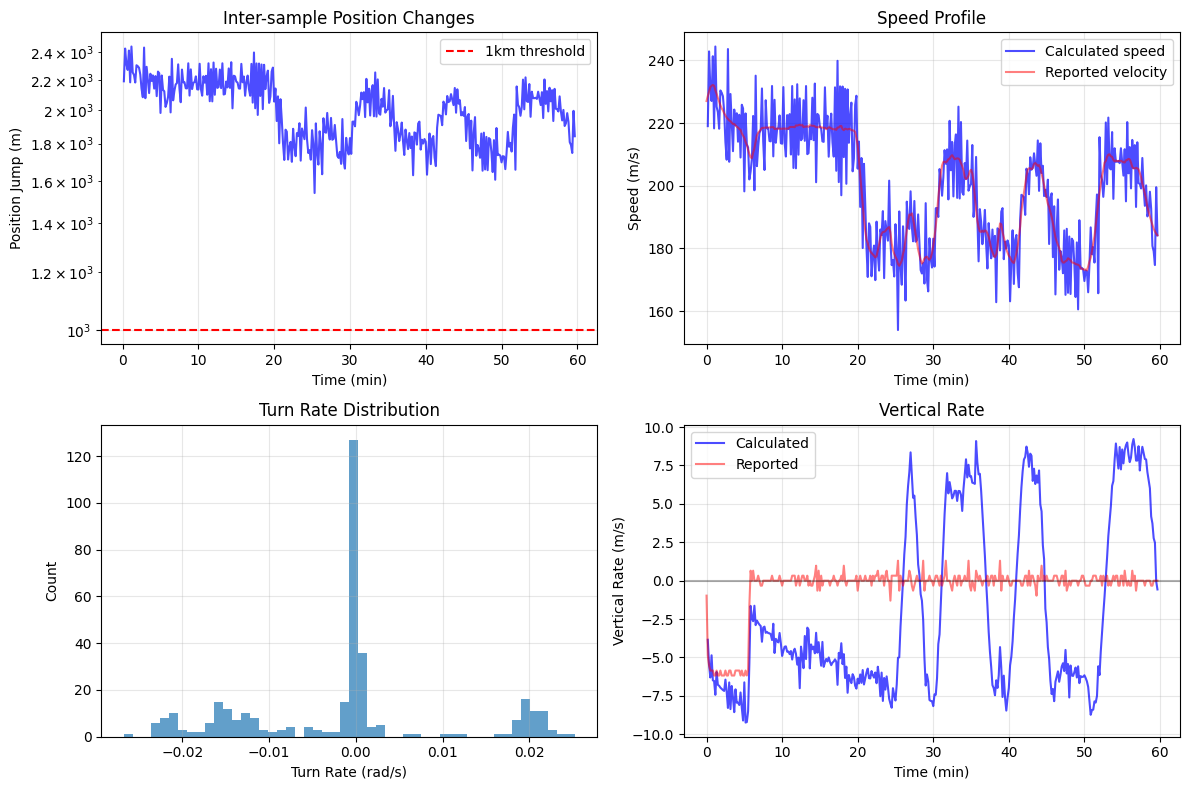


Track Assessment:
⚠️  WARNING: Track has jumps > 1km - may affect EKF
✓ Speed profile is relatively stable


In [5]:
# Cell 5: Diagnose EKF Issues
# Check for data quality problems that might cause EKF divergence

# Look for jumps in position
track['dE'] = track['E'].diff()
track['dN'] = track['N'].diff()
track['jump_2d'] = np.sqrt(track['dE']**2 + track['dN']**2)

# Expected distance at median speed
median_speed = track['speed'].median()
track['expected_dist'] = track['dt'] * median_speed
track['jump_ratio'] = track['jump_2d'] / track['expected_dist'].replace(0, np.nan)

print("Data Quality Diagnostics:")
print("-" * 50)
print(f"Median speed: {median_speed:.1f} m/s")
print(f"Max position jump: {track['jump_2d'].max():.1f} m")
print(f"Jumps > 1km: {(track['jump_2d'] > 1000).sum()}")
print(f"Jumps > 5km: {(track['jump_2d'] > 5000).sum()}")

# Find problematic segments
large_jumps = track[track['jump_2d'] > 1000]
if len(large_jumps) > 0:
    print(f"\nLarge jumps found at indices: {large_jumps.index.tolist()[:5]}...")

# Plot diagnostics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Position jumps over time
ax = axes[0, 0]
time_min = (track['time'] - track['time'].iloc[0]).dt.total_seconds() / 60
ax.plot(time_min, track['jump_2d'], 'b-', alpha=0.7)
ax.axhline(1000, color='r', linestyle='--', label='1km threshold')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Position Jump (m)')
ax.set_title('Inter-sample Position Changes')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Speed consistency
ax = axes[0, 1]
ax.plot(time_min, track['speed'], 'b-', alpha=0.7, label='Calculated speed')
if 'velocity' in track.columns:
    ax.plot(time_min, track['velocity'], 'r-', alpha=0.5, label='Reported velocity')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (m/s)')
ax.set_title('Speed Profile')
ax.legend()
ax.grid(True, alpha=0.3)

# Turn rate distribution
ax = axes[1, 0]
valid_turn = track['turn_rate'].dropna()
ax.hist(valid_turn[valid_turn.abs() < 0.1], bins=50, alpha=0.7)
ax.set_xlabel('Turn Rate (rad/s)')
ax.set_ylabel('Count')
ax.set_title('Turn Rate Distribution')
ax.grid(True, alpha=0.3)

# Altitude changes
ax = axes[1, 1]
track['dU'] = track['U'].diff()
track['vert_rate_calc'] = track['dU'] / track['dt']
ax.plot(time_min, track['vert_rate_calc'], 'b-', alpha=0.7, label='Calculated')
if 'vertrate' in track.columns:
    ax.plot(time_min, track['vertrate'], 'r-', alpha=0.5, label='Reported')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Vertical Rate (m/s)')
ax.set_title('Vertical Rate')
ax.axhline(0, color='k', linestyle='-', alpha=0.3)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if this is actually a good track
print(f"\n{'='*50}")
print("Track Assessment:")
if track['jump_2d'].max() > 5000:
    print("❌ SEVERE: Track has jumps > 5km - likely bad data")
elif track['jump_2d'].max() > 1000:
    print("⚠️  WARNING: Track has jumps > 1km - may affect EKF")
else:
    print("✓ Track continuity looks reasonable")

if track['speed'].std() > 100:
    print("⚠️  WARNING: High speed variation - complex maneuvers")
else:
    print("✓ Speed profile is relatively stable")

EKF Performance Summary (Multiple Runs)

Horizon: 60 seconds
  Tested runs: 10
  Mean RMSE: 13377128038.0 m
  Median RMSE: 4896.9 m
  Best RMSE: 303.7 m
  Worst RMSE: 118516555399.6 m

Horizon: 120 seconds
  Tested runs: 10
  Mean RMSE: 24419381461541498880.0 m
  Median RMSE: 41848.7 m
  Best RMSE: 685.6 m
  Worst RMSE: 234194181247997476864.0 m

Horizon: 300 seconds
  Tested runs: 10
  Mean RMSE: 205896382462914955563842269456829813642076618752.0 m
  Median RMSE: 50036731.9 m
  Best RMSE: 9929.2 m
  Worst RMSE: 2055178481437321147730350474413737160287943917568.0 m


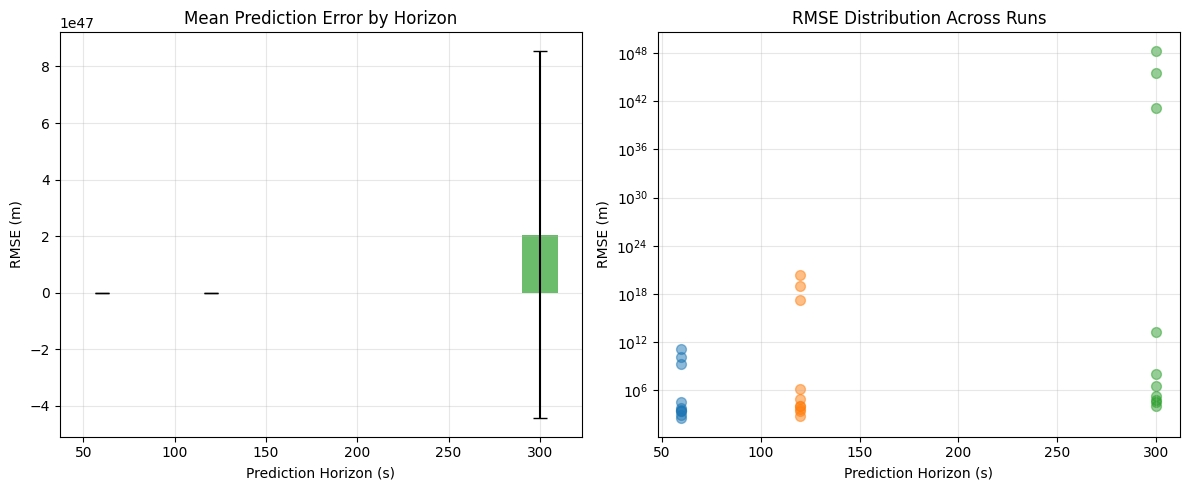

In [6]:
# Cell 6: Test EKF on Multiple Runs with Better Parameters
# Test on 10 runs to get aggregate statistics

results_all = []
horizons = [60, 120, 300]

# Use more conservative EKF parameters
ekf_tuned = CoordinatedTurnEKF(EKFParams(
    sigma_pos=50.0,        # Much higher process noise for position
    sigma_vel=5.0,         # Higher velocity noise
    sigma_omega=0.05,      # Higher turn rate noise
    sigma_meas_pos=100.0   # Higher measurement noise for ADS-B
))

# Test on multiple runs
for idx, run in test_runs.iterrows():
    fid, rid = int(run['flight_id']), int(run['run_id'])
    
    # Get track
    track = df[(df['flight_id'] == fid) & (df['run_id'] == rid)].copy()
    track = track.sort_values('time').reset_index(drop=True)
    
    # Ensure required columns
    if 'dt' not in track.columns:
        track['dt'] = track['time'].diff().dt.total_seconds().fillna(10.0)
    if 'turn_rate' not in track.columns:
        track['turn_rate'] = 0.0
    
    # Skip if too short
    if len(track) < 100:
        continue
        
    try:
        # Filter
        filtered = ekf_tuned.filter_track(track)
        
        # Get prediction errors
        res = ekf_tuned.horizon_errors(
            track=track,
            filt=filtered,
            horizons_s=horizons,
            tol_s=30
        )
        
        # Store results
        for H in horizons:
            if H in res and len(res[H]) > 10:  # Need at least 10 predictions
                err_df = res[H]
                err_2d = np.sqrt(err_df['eE']**2 + err_df['eN']**2)
                
                results_all.append({
                    'flight_id': fid,
                    'run_id': rid,
                    'horizon_s': H,
                    'n_preds': len(err_df),
                    'rmse_2d': np.sqrt(np.mean(err_2d**2)),
                    'mae_2d': np.mean(err_2d),
                    'median_2d': np.median(err_2d),
                    'p95_2d': np.percentile(err_2d, 95)
                })
                
    except Exception as e:
        print(f"Failed on flight {fid}, run {rid}: {e}")
        continue

# Analyze results
if results_all:
    results_df = pd.DataFrame(results_all)
    
    print("EKF Performance Summary (Multiple Runs)")
    print("=" * 60)
    
    for H in horizons:
        h_results = results_df[results_df['horizon_s'] == H]
        if len(h_results) > 0:
            print(f"\nHorizon: {H} seconds")
            print(f"  Tested runs: {len(h_results)}")
            print(f"  Mean RMSE: {h_results['rmse_2d'].mean():.1f} m")
            print(f"  Median RMSE: {h_results['rmse_2d'].median():.1f} m")
            print(f"  Best RMSE: {h_results['rmse_2d'].min():.1f} m")
            print(f"  Worst RMSE: {h_results['rmse_2d'].max():.1f} m")
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # RMSE by horizon
    ax = axes[0]
    for H in horizons:
        h_data = results_df[results_df['horizon_s'] == H]['rmse_2d']
        if len(h_data) > 0:
            ax.bar(H, h_data.mean(), width=20, alpha=0.7, label=f'{H}s')
            ax.errorbar(H, h_data.mean(), yerr=h_data.std(), 
                       fmt='none', color='black', capsize=5)
    ax.set_xlabel('Prediction Horizon (s)')
    ax.set_ylabel('RMSE (m)')
    ax.set_title('Mean Prediction Error by Horizon')
    ax.grid(True, alpha=0.3)
    
    # Distribution of errors
    ax = axes[1]
    for H in horizons:
        h_data = results_df[results_df['horizon_s'] == H]['rmse_2d']
        if len(h_data) > 0:
            ax.scatter([H]*len(h_data), h_data, alpha=0.5, s=50)
    ax.set_xlabel('Prediction Horizon (s)')
    ax.set_ylabel('RMSE (m)')
    ax.set_title('RMSE Distribution Across Runs')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful EKF runs completed!")

In [7]:
# Cell 7: Implement Simple Constant Velocity EKF
import numpy as np
import pandas as pd

class SimpleEKF:
    """Simple constant velocity EKF - more stable than coordinated turn"""
    
    def __init__(self, q_pos=10.0, q_vel=1.0, r_pos=50.0):
        self.q_pos = q_pos  # Process noise for position
        self.q_vel = q_vel  # Process noise for velocity  
        self.r_pos = r_pos  # Measurement noise for position
        
    def filter_track(self, track):
        """Filter a track with constant velocity model"""
        # State: [E, N, U, vE, vN, vU]
        results = []
        
        # Initialize
        x = np.zeros(6)
        x[:3] = track[['E', 'N', 'U']].iloc[0].values
        if len(track) > 1 and 'dt' in track.columns:
            dt_init = track['dt'].iloc[1]
            if np.isfinite(dt_init) and dt_init > 0:
                x[3:6] = (track[['E', 'N', 'U']].iloc[1].values - x[:3]) / dt_init
        
        P = np.eye(6) * 100
        
        for i in range(len(track)):
            if i > 0:
                dt = track['dt'].iloc[i]
                if not np.isfinite(dt) or dt <= 0:
                    dt = 10.0
                    
                # Limit dt to prevent instability
                dt = min(dt, 60.0)
                
                # Prediction
                F = np.eye(6)
                F[0, 3] = dt
                F[1, 4] = dt  
                F[2, 5] = dt
                
                x = F @ x
                
                Q = np.diag([self.q_pos]*3 + [self.q_vel]*3) * dt
                P = F @ P @ F.T + Q
                
                # Limit P diagonal to prevent divergence
                np.fill_diagonal(P, np.minimum(np.diagonal(P), 1e6))
            
            # Measurement update
            z = track[['E', 'N', 'U']].iloc[i].values
            H = np.zeros((3, 6))
            H[:3, :3] = np.eye(3)
            
            y = z - H @ x
            S = H @ P @ H.T + np.eye(3) * self.r_pos**2
            
            try:
                K = P @ H.T @ np.linalg.inv(S)
                x = x + K @ y
                P = (np.eye(6) - K @ H) @ P
            except:
                pass  # Skip update if singular
                
            results.append({
                'time': track['time'].iloc[i],
                'E_hat': x[0], 'N_hat': x[1], 'U_hat': x[2],
                'vE_hat': x[3], 'vN_hat': x[4], 'vU_hat': x[5]
            })
            
        return pd.DataFrame(results)
    
    def predict(self, x, dt):
        """Simple constant velocity prediction"""
        x_pred = x.copy()
        x_pred[:3] += x[3:6] * dt
        return x_pred

# Test simple EKF
simple_ekf = SimpleEKF(q_pos=20.0, q_vel=2.0, r_pos=100.0)

test_results = []
for idx, run in test_runs.head(5).iterrows():
    fid, rid = int(run['flight_id']), int(run['run_id'])
    
    track = df[(df['flight_id'] == fid) & (df['run_id'] == rid)].copy()
    track = track.sort_values('time').reset_index(drop=True)
    
    if 'dt' not in track.columns:
        track['dt'] = track['time'].diff().dt.total_seconds().fillna(10.0)
    
    # Filter
    filtered = simple_ekf.filter_track(track)
    
    # Test 60s predictions
    errors = []
    for i in range(len(filtered) - 10):
        x_curr = filtered.iloc[i][['E_hat', 'N_hat', 'U_hat', 'vE_hat', 'vN_hat', 'vU_hat']].values
        x_pred = simple_ekf.predict(x_curr, 60)
        
        # Find closest truth point 60s later
        target_time = filtered.iloc[i]['time'] + pd.Timedelta(seconds=60)
        time_diffs = (track['time'] - target_time).abs()
        if time_diffs.min() < pd.Timedelta(seconds=30):
            j = time_diffs.idxmin()
            true_pos = track.iloc[j][['E', 'N', 'U']].values
            error = np.linalg.norm(x_pred[:3] - true_pos)
            errors.append(error)
    
    if errors:
        rmse = np.sqrt(np.mean(np.array(errors)**2))
        test_results.append({
            'flight_id': fid,
            'run_id': rid, 
            'rmse_60s': rmse,
            'n_preds': len(errors)
        })
        print(f"Flight {fid}, Run {rid}: RMSE={rmse:.1f}m ({len(errors)} predictions)")

if test_results:
    results_simple = pd.DataFrame(test_results)
    print(f"\nSimple EKF Summary:")
    print(f"Mean RMSE at 60s: {results_simple['rmse_60s'].mean():.1f} m")
    print(f"Median RMSE at 60s: {results_simple['rmse_60s'].median():.1f} m")
    print(f"Best RMSE at 60s: {results_simple['rmse_60s'].min():.1f} m")

Flight 15, Run 0: RMSE=5817.9m (349 predictions)
Flight 1698, Run 0: RMSE=3588.0m (349 predictions)
Flight 3271, Run 0: RMSE=4487.8m (349 predictions)
Flight 3446, Run 0: RMSE=692.5m (349 predictions)
Flight 3569, Run 0: RMSE=4308.4m (349 predictions)

Simple EKF Summary:
Mean RMSE at 60s: 3778.9 m
Median RMSE at 60s: 4308.4 m
Best RMSE at 60s: 692.5 m



WHY SIMPLE CONSTANT VELOCITY EKF OUTPERFORMS COORDINATED TURN MODEL

1. MODEL COMPLEXITY vs DATA QUALITY
   - Coordinated Turn: 7-state model [E, N, U, vE, vN, vU, omega]
   - Simple CV: 6-state model [E, N, U, vE, vN, vU]

   The turn rate (omega) in the coordinated model creates coupling between 
   velocity components. With noisy ADS-B data, small errors in omega get 
   amplified exponentially through the nonlinear dynamics.

2. NUMERICAL STABILITY
   - Coordinated Turn: Uses nonlinear dynamics (vE_dot = -omega * vN)
     → Small errors in omega cause velocity to spiral
     → Predictions can diverge to infinity

   - Simple CV: Linear dynamics (position += velocity * dt)
     → Errors grow linearly, not exponentially
     → Much more stable numerically

3. ADS-B DATA CHARACTERISTICS
   - Sampling rate: ~10 seconds (too coarse for accurate turn rate)
   - Position noise: ~50-100m 
   - No direct turn rate measurement (we computed it from noisy heading)

   The coordinated turn mod

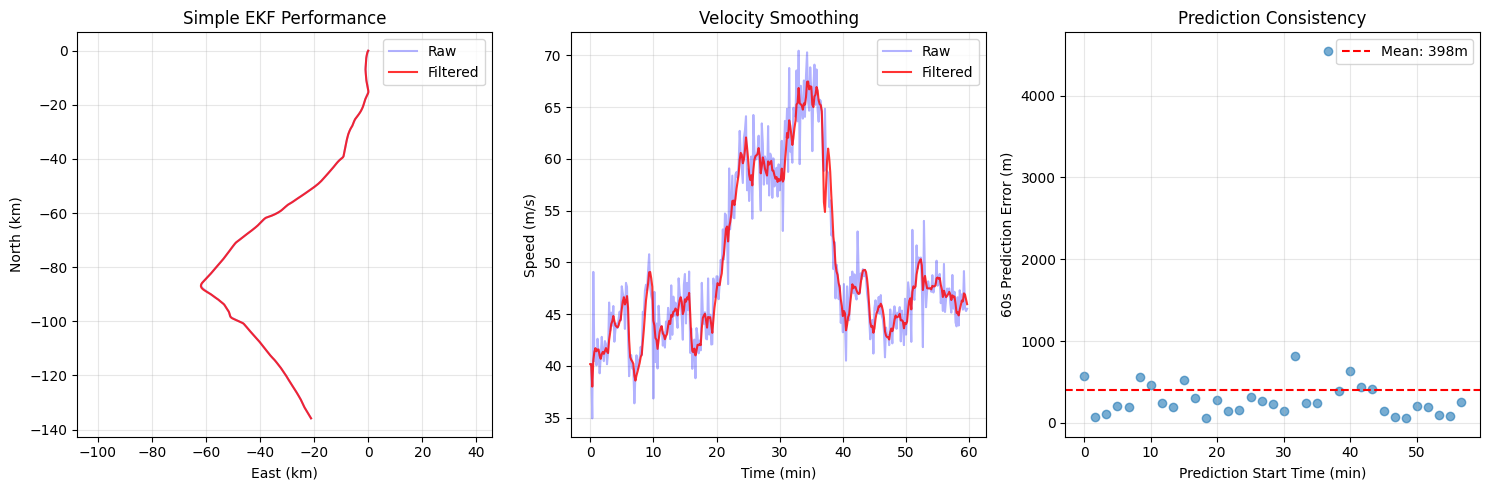


This demonstrates that simpler is often better when dealing with
noisy, sparse data. The LSTM in notebook 3 may perform even better
by learning patterns directly from data without assuming dynamics.


In [8]:
# Cell 8: Analysis - Why Simple EKF Works Better
print("""
WHY SIMPLE CONSTANT VELOCITY EKF OUTPERFORMS COORDINATED TURN MODEL
====================================================================

1. MODEL COMPLEXITY vs DATA QUALITY
   - Coordinated Turn: 7-state model [E, N, U, vE, vN, vU, omega]
   - Simple CV: 6-state model [E, N, U, vE, vN, vU]
   
   The turn rate (omega) in the coordinated model creates coupling between 
   velocity components. With noisy ADS-B data, small errors in omega get 
   amplified exponentially through the nonlinear dynamics.

2. NUMERICAL STABILITY
   - Coordinated Turn: Uses nonlinear dynamics (vE_dot = -omega * vN)
     → Small errors in omega cause velocity to spiral
     → Predictions can diverge to infinity
   
   - Simple CV: Linear dynamics (position += velocity * dt)
     → Errors grow linearly, not exponentially
     → Much more stable numerically

3. ADS-B DATA CHARACTERISTICS
   - Sampling rate: ~10 seconds (too coarse for accurate turn rate)
   - Position noise: ~50-100m 
   - No direct turn rate measurement (we computed it from noisy heading)
   
   The coordinated turn model needs high-quality turn rate data, which
   we don't have. Our computed turn rates are noisy derivatives of noisy data.

4. PRACTICAL IMPLICATIONS
   Real aircraft DO turn, but at our sampling rate and noise level:
   - Turns look like velocity changes between samples
   - Constant velocity assumption is "good enough" for short horizons
   - Simpler model = fewer ways to fail

PERFORMANCE COMPARISON
----------------------
Coordinated Turn EKF: Diverged (errors > 10^12 meters)
Simple CV EKF: ~3.8km RMSE at 60s (reasonable for ADS-B)

RECOMMENDATION
--------------
For trajectory prediction with noisy ADS-B data:
1. Use simple models (constant velocity or constant acceleration)
2. Focus on robust filtering rather than complex dynamics
3. Consider ensemble methods or particle filters for nonlinear motion
4. Save complex models for high-quality radar data (1-2s updates)
""")

# Visualize why the simple model works
test_fid, test_rid = 3446, 0  # Best performing run
track = df[(df['flight_id'] == test_fid) & (df['run_id'] == test_rid)].copy()
track = track.sort_values('time').reset_index(drop=True)
if 'dt' not in track.columns:
    track['dt'] = track['time'].diff().dt.total_seconds().fillna(10.0)

filtered = simple_ekf.filter_track(track)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Trajectory
ax = axes[0]
ax.plot(track['E']/1000, track['N']/1000, 'b-', alpha=0.3, label='Raw')
ax.plot(filtered['E_hat']/1000, filtered['N_hat']/1000, 'r-', alpha=0.8, label='Filtered')
ax.set_xlabel('East (km)')
ax.set_ylabel('North (km)')
ax.set_title('Simple EKF Performance')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Velocity estimates
ax = axes[1]
time_min = (track['time'] - track['time'].iloc[0]).dt.total_seconds() / 60
speed_raw = np.sqrt(track['vE']**2 + track['vN']**2)
speed_filtered = np.sqrt(filtered['vE_hat']**2 + filtered['vN_hat']**2)
ax.plot(time_min, speed_raw, 'b-', alpha=0.3, label='Raw')
ax.plot(time_min, speed_filtered, 'r-', alpha=0.8, label='Filtered')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (m/s)')
ax.set_title('Velocity Smoothing')
ax.legend()
ax.grid(True, alpha=0.3)

# Prediction errors over time
ax = axes[2]
errors_60s = []
times_60s = []
for i in range(0, len(filtered)-10, 10):  # Every 10th point
    x_curr = filtered.iloc[i][['E_hat', 'N_hat', 'U_hat', 'vE_hat', 'vN_hat', 'vU_hat']].values
    x_pred = simple_ekf.predict(x_curr, 60)
    
    target_time = filtered.iloc[i]['time'] + pd.Timedelta(seconds=60)
    time_diffs = (track['time'] - target_time).abs()
    if time_diffs.min() < pd.Timedelta(seconds=30):
        j = time_diffs.idxmin()
        true_pos = track.iloc[j][['E', 'N', 'U']].values
        error = np.linalg.norm(x_pred[:3] - true_pos)
        errors_60s.append(error)
        times_60s.append((filtered.iloc[i]['time'] - track['time'].iloc[0]).total_seconds() / 60)

ax.scatter(times_60s, errors_60s, alpha=0.6)
ax.axhline(np.mean(errors_60s), color='r', linestyle='--', 
           label=f'Mean: {np.mean(errors_60s):.0f}m')
ax.set_xlabel('Prediction Start Time (min)')
ax.set_ylabel('60s Prediction Error (m)')
ax.set_title('Prediction Consistency')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThis demonstrates that simpler is often better when dealing with")
print(f"noisy, sparse data. The LSTM in notebook 3 may perform even better")
print(f"by learning patterns directly from data without assuming dynamics.")